###Detect fake profiles using SVM

In [1]:
!pip install gender-guesser

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import csv
import gender_guesser.detector as gender
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.3 MB/s eta 0:00:00


In [2]:
import seaborn as sns

In [26]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("genuineusers.csv")
    fake_users = pd.read_csv("fakeusers.csv")
    combined_users = pd.concat([genuine_users, fake_users])
    labels = len(fake_users) * [0] + len(genuine_users) * [1]
    return combined_users, labels

In [8]:
genuine_users = pd.read_csv("genuineusers.csv")
fake_users = pd.read_csv("fakeusers.csv")
labels = len(fake_users) * [0] + len(genuine_users) * [1]
combined_users = pd.concat([genuine_users, fake_users])
summary = combined_users.describe()
summary

,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,protected,verified
count,2.818000e+03,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,1728.0,8.0,721.0,2760.0,489.0,1069.000000,0.0,0.0
mean,5.374889e+08,1672.198368,371.105039,395.363023,234.541164,2.818666,1.0,1.0,1.0,1.0,1.0,1478.391020,NaN,NaN
std,2.977005e+08,4884.669157,8022.631339,465.694322,1445.847248,23.480430,0.0,0.0,0.0,0.0,0.0,8108.211889,NaN,NaN
min,3.610511e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN
25%,3.620867e+08,35.000000,17.000000,168.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
50%,6.162253e+08,77.000000,26.000000,306.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
75%,6.177673e+08,1087.750000,111.000000,519.000000,37.000000,1.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
max,1.391998e+09,79876.000000,408372.000000,12773.000000,44349.000000,744.000000,1.0,1.0,1.0,1.0,1.0,36000.000000,NaN,NaN


In [6]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to max
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            8 non-null      float64
 1   statuses_count                8 non-null      float64
 2   followers_count               8 non-null      float64
 3   friends_count                 8 non-null      float64
 4   favourites_count              8 non-null      float64
 5   listed_count                  8 non-null      float64
 6   default_profile               8 non-null      float64
 7   default_profile_image         8 non-null      float64
 8   geo_enabled                   8 non-null      float64
 9   profile_use_background_image  8 non-null      float64
 10  profile_background_tile       8 non-null      float64
 11  utc_offset                    8 non-null      float64
 12  protected                     1 non-null      float64
 13  verified

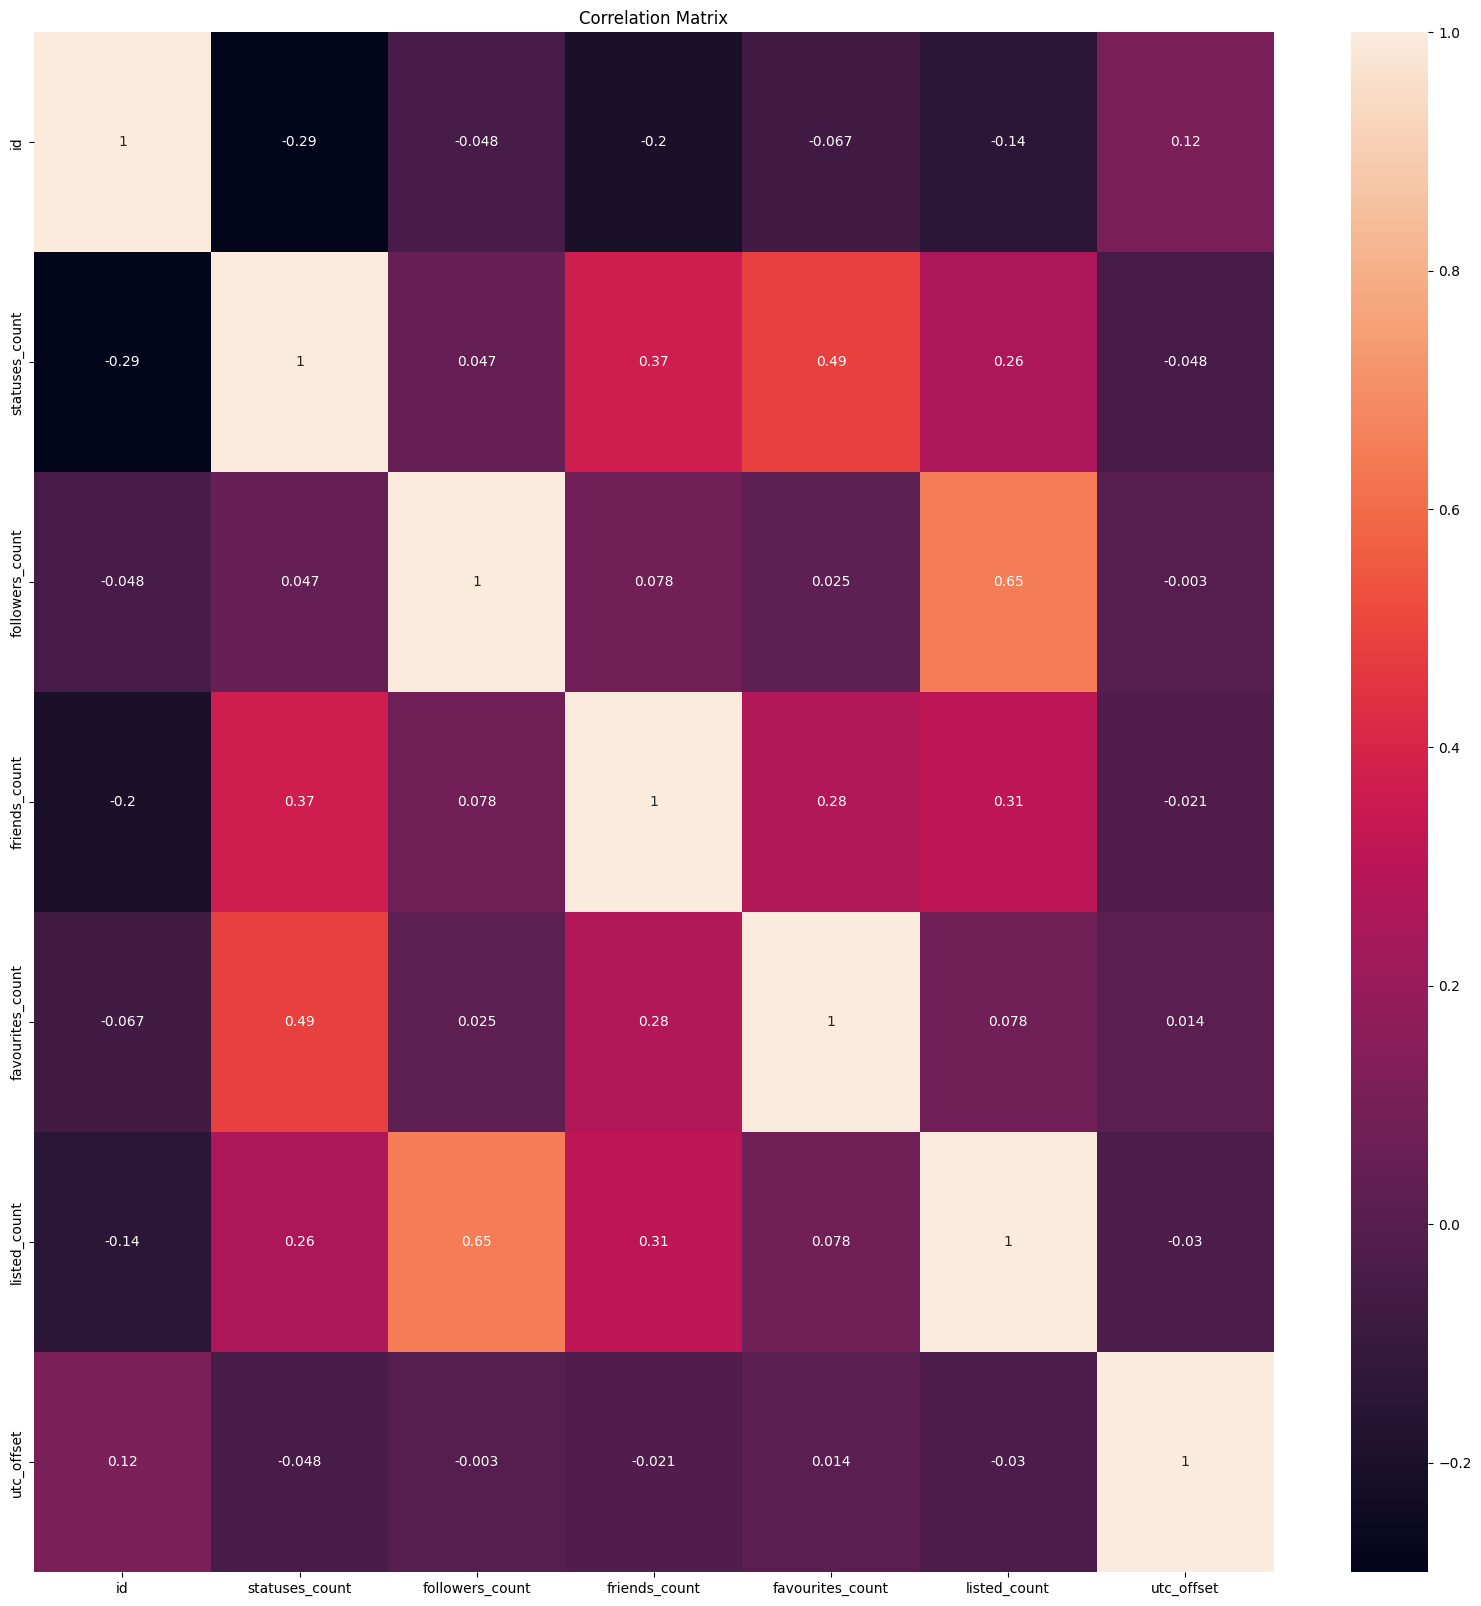

In [10]:
numeric_columns = combined_users.select_dtypes(include=['float64', 'int64'])
# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()
correlation_matrix = correlation_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
plt.figure(figsize=(20, 20))
ax = plt.subplot()
sns.heatmap(correlation_matrix, annot=True, ax=ax)
plt.title('Correlation Matrix')
plt.show()

In [11]:
def predict_gender(name_series):
    gender_detector = gender.Detector(case_sensitive=False)
    first_name = name_series.str.split(' ').str.get(0)
    gender_prediction = first_name.apply(gender_detector.get_gender)
    gender_map = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'mostly_male': 1, 'male': 2}
    gender_code = gender_prediction.map(gender_map)

    # Fill NaN values with a default value (e.g., 0 for 'unknown')
    gender_code = gender_code.fillna(0).astype(int)

    return gender_code


In [12]:
def extract_features(dataframe):
    lang_list = list(enumerate(np.unique(dataframe['lang'])))
    lang_dict = {name: i for i, name in lang_list}
    dataframe.loc[:, 'lang_code'] = dataframe['lang'].map(lambda x: lang_dict[x]).astype(int)
    dataframe.loc[:, 'gender_code'] = predict_gender(dataframe['name'])
    feature_columns_to_use = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'gender_code', 'lang_code']
    dataframe = dataframe.loc[:, feature_columns_to_use]
    return dataframe

######function for ploting learning curve

In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

######function for plotting confusion matrix

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names = ['Fake', 'Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######function for plotting ROC curve

In [15]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print("False Positive rate: ", false_positive_rate)
    print("True Positive rate: ", true_positive_rate)

    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [16]:
def train(X_train, y_train, X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2, 3, .5)
    gammas = 10.0 ** np.arange(-2, 3, .5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=5)
    classifier = SVC()
    grid_search = GridSearchCV(classifier, param_grid=param, cv=cvk)
    grid_search.fit(X_train, y_train)
    print("The best classifier is: ", grid_search.best_estimator_)
    grid_search.best_estimator_.fit(X_train, y_train)
    # Estimate score
    scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' % grid_search.best_estimator_.gamma
    plot_learning_curve(grid_search.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = grid_search.best_estimator_.predict(X_test)
    return y_test, y_pred


In [18]:
combined_users = extract_features(combined_users)
print(combined_users.columns)
print(combined_users.describe())

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'gender_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count  gender_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.191270     2.851313  
std       23.480430     1

In [19]:
X_train, X_test, y_train, y_test = train_test_split(combined_users, labels, test_size=0.20, random_state=44)

training datasets.......

The best classifier is:  SVC(gamma=100.0)
[0.92017738 0.92239468 0.92682927 0.9578714  0.94      ]
Estimated score: 0.93345 (+/- 0.00701)


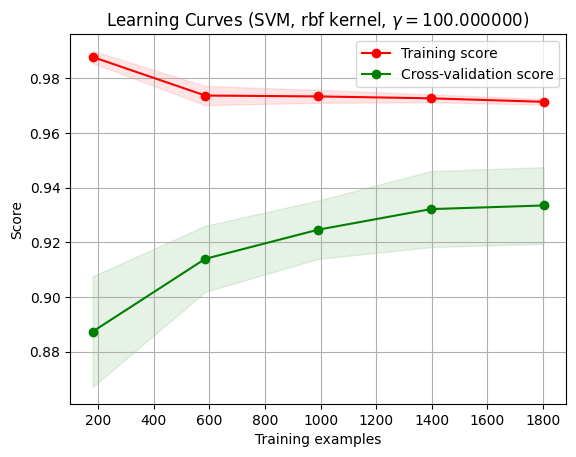

In [27]:
print ("training datasets.....\n")
y_test, y_pred = train(X_train, y_train, X_test)

In [21]:
print('Classification Accuracy on Test dataset: ', accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.898936170212766


Confusion matrix, without normalization
[[264   4]
 [ 53 243]]


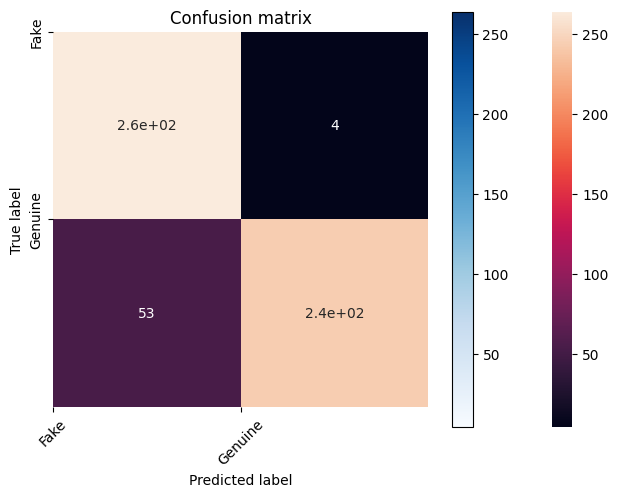

In [22]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
sns.heatmap(cm, annot=True)
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.98507463 0.01492537]
 [0.17905405 0.82094595]]


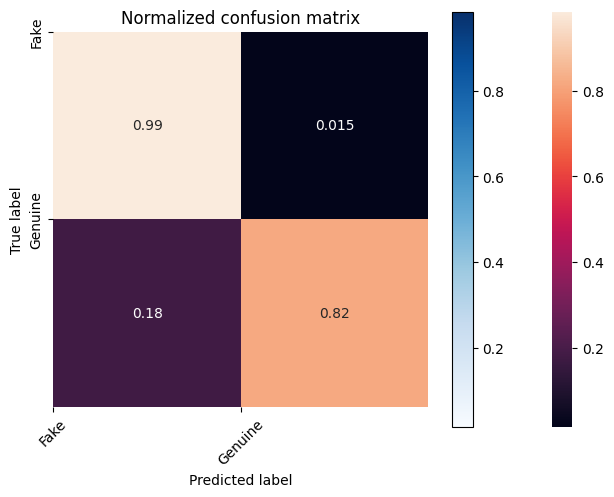

In [23]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
sns.heatmap(cm_normalized, annot=True)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [24]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.83      0.99      0.90       268
     Genuine       0.98      0.82      0.90       296

    accuracy                           0.90       564
   macro avg       0.91      0.90      0.90       564
weighted avg       0.91      0.90      0.90       564



False Positive rate:  [0.         0.01492537 1.        ]
True Positive rate:  [0.         0.82094595 1.        ]


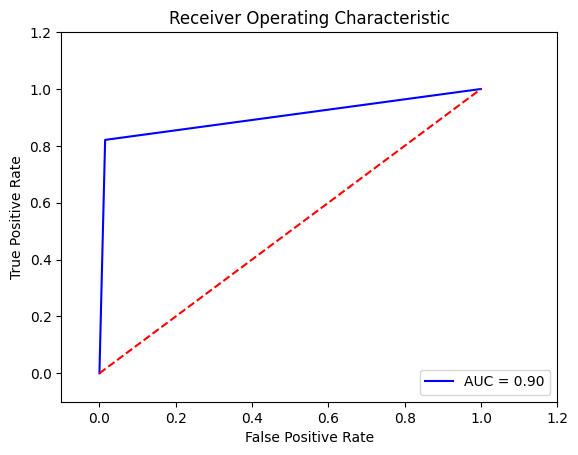

In [25]:
plot_roc_curve(y_test, y_pred)